<!-- # Business Goal - 
# To segement the Customers based on recency, frequency and quantity of purchase
# so that the company can target its customers efficiently. -->

Business Goal - 
To segement the Customers based on Recency, Frequency and Amount of Puchase so that the company can target its customers efficiently.

In [146]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram


### Reading Data

In [147]:
onlineretail = pd.read_csv('OnlineRetail.csv',encoding= 'unicode_escape')
print("Dataset shape", onlineretail.shape)
# Displaying top 5 rows of dataset
onlineretail.head()

Dataset shape (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


### Preprocessing Data

In [148]:
# Discarding all blank custoemr IDs
print("Percentage of blank records:\n",onlineretail.isnull().sum()*100/onlineretail.shape[0])
onlineretail.dropna(axis=0, subset=['CustomerID'],inplace=True)
onlineretail.reset_index(inplace=True)
print("\n New Dataset shape after discarding null custome ids", onlineretail.shape)

# Changing Custoemr ID type from float to string
onlineretail["CustomerID"]=onlineretail["CustomerID"].astype('int64').astype('str')

Percentage of blank records:
 InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

 New Dataset shape after discarding null custome ids (406829, 9)


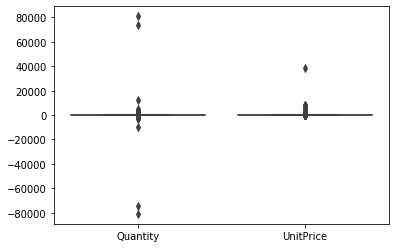

In [149]:
# Analysing numerci data attributes
attributes=["Quantity","UnitPrice"]

sns.boxplot(data=onlineretail[attributes])



In [150]:

# Calculating recency
onlineretail["InvoiceDate"]=pd.to_datetime(onlineretail["InvoiceDate"], format = '%d-%m-%Y %H:%M')

max_date=max(onlineretail["InvoiceDate"])
onlineretail["recency"]=max_date-onlineretail["InvoiceDate"]
onlineretail["recency"]=onlineretail["recency"].dt.days

In [151]:
print("Total no. of unique customer ids:")
onlineretail["CustomerID"].value_counts().shape


Total no. of unique customer ids:


(4372,)

In [152]:
# Calculating total amount per customer id
onlineretail['amount']=onlineretail.UnitPrice*onlineretail.Quantity


df1=onlineretail.groupby('CustomerID')['amount'].sum()
df1=df1.to_frame()
df1.reset_index(inplace=True)


# Calculating recency as per most recent purchase per customer id
df2=onlineretail.groupby('CustomerID')['recency'].min()
df2=df2.to_frame()
df2.reset_index(inplace=True)


# Calculating fequency aka total no of purchases per customer 
df3=onlineretail.groupby('CustomerID')['InvoiceNo'].count()
df3=df3.to_frame()
df3.rename(columns={'InvoiceNo': 'frequency'},inplace=True)
df3.reset_index(inplace=True)

df4=df1.merge(df2,on='CustomerID',how='inner')


df5=df4.merge(df3,on='CustomerID',how='inner')

df5.describe()


,amount,recency,frequency
count,4372.000000,4372.000000,4372.000000
mean,1898.459701,91.047118,93.053294
std,8219.345141,100.765435,232.471608
min,-4287.630000,0.000000,1.000000
25%,293.362500,16.000000,17.000000
50%,648.075000,49.000000,42.000000
75%,1611.725000,142.000000,102.000000
max,279489.020000,373.000000,7983.000000


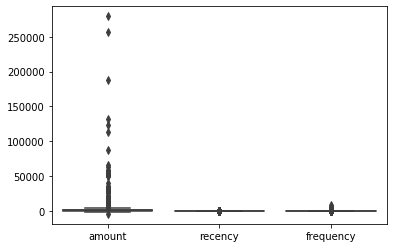

In [153]:

attributes=["amount","recency","frequency"]

sns.boxplot(data=df5[attributes])


In [154]:
# Removing outliers if values ae outside of 1.5*IQR
a_q1 = df5['amount'].quantile(0.25)
a_q3 = df5['amount'].quantile(0.75)
a_iqr = a_q3-a_q1
df5=df5[~((df5['amount'] < (a_q1 - 1.5 * a_iqr)) |(df5['amount'] > (a_q3 + 1.5 * a_iqr)))]


f_q1 = df5['frequency'].quantile(0.25)
f_q3 = df5['frequency'].quantile(0.75)
f_iqr = f_q3-f_q1
df5=df5[~((df5['frequency'] < (f_q1 - 1.5 * f_iqr)) |(df5['frequency'] > (f_q3 + 1.5 * f_iqr)))]

df5.shape

(3697, 4)

In [155]:
# Rescaling the values before clustering
df6=df5[['amount','recency','frequency']]
scaler = StandardScaler()
df6_scaled = scaler.fit_transform(df6)

In [156]:
df6_scaled = pd.DataFrame(df6_scaled)
df6_scaled.columns=['amount','recency','frequency']
df6_scaled.shape

(3697, 3)

### Building Model

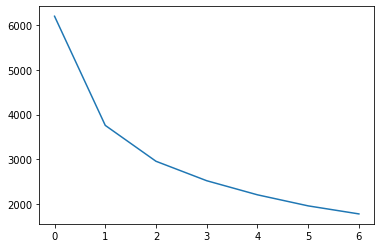

In [157]:
# K Means Clustering
# Calculating optimal no of clusters through elbow plot
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    km = KMeans(n_clusters=num_clusters, max_iter=200,n_init=50,random_state=8)
    km.fit(df6_scaled)

    ssd.append(km.inertia_)

# plot the SSDs for each n_clusters
plt.plot(ssd)


In [158]:
# Calculating optimal no of clusters through silhouette score

for num_clusters in range_n_clusters:

    # intialise kmeans
    km = KMeans(n_clusters=num_clusters, max_iter=200,n_init=50,random_state=8)
    km.fit(df6_scaled)

    cluster_labels = km.labels_

    # silhouette score
    silhouette_avg = silhouette_score(df6_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.4292946797663935
For n_clusters=3, the silhouette score is 0.43933529055238923
For n_clusters=4, the silhouette score is 0.40851721359807264
For n_clusters=5, the silhouette score is 0.38940731623509356
For n_clusters=6, the silhouette score is 0.35689776191850253
For n_clusters=7, the silhouette score is 0.3324882777917836
For n_clusters=8, the silhouette score is 0.34115209918940537


In [159]:

km =  KMeans(n_clusters=3,max_iter=200,n_init=50,random_state=8)
km.fit(df6_scaled)
df5['Cluster_Id']=km.labels_

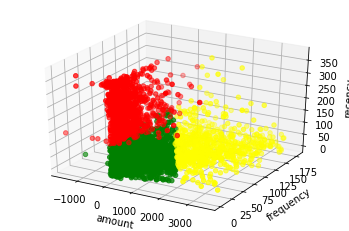

In [160]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

c = {0:'red', 1:'yellow', 2:'green'}

grouped = df5.groupby('Cluster_Id')
for key, group in grouped:
    e=c.get(key)
    ax.scatter(group['amount'], group['frequency'], group['recency'], color=e)
    
ax.set_xlabel('amount')
ax.set_ylabel('frequency')
ax.set_zlabel('recency')
plt.show()

##### Analysing clusters via boxplots

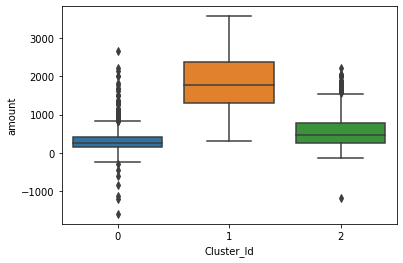

In [161]:
sns.boxplot(x='Cluster_Id', y='amount', data=df5)


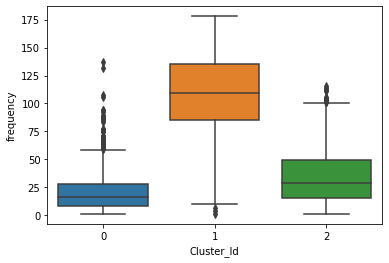

In [162]:
sns.boxplot(x='Cluster_Id', y='frequency', data=df5)


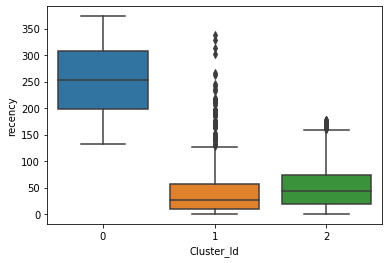

In [163]:
sns.boxplot(x='Cluster_Id', y='recency', data=df5)

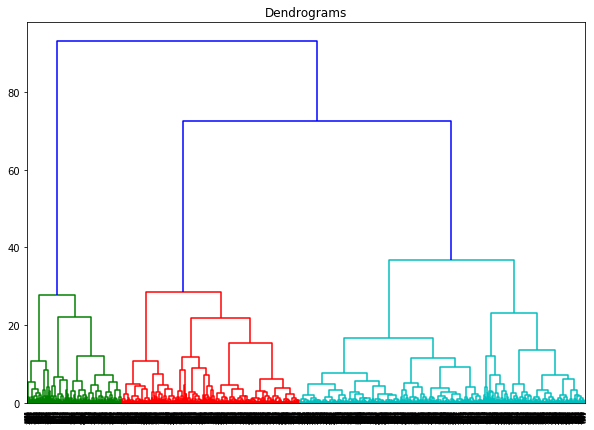

In [164]:
# Hierarchical Clustering
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(df6_scaled, method='ward'))


In [165]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(df6_scaled)

array([2, 0, 1, ..., 2, 0, 1], dtype=int64)

In [171]:
df5['cid']=cluster.fit_predict(df6_scaled)

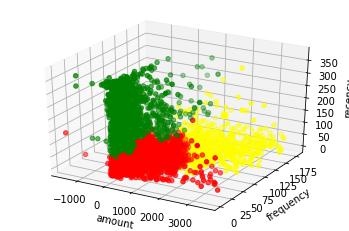

In [172]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
c = {0:'red', 1:'yellow', 2:'green'}

grouped = df5.groupby('cid')
for key, group in grouped:
    e=c.get(key)
    ax.scatter(group['amount'], group['frequency'], group['recency'], color=e)
ax.set_xlabel('amount')
ax.set_ylabel('frequency')
ax.set_zlabel('recency')

plt.show()

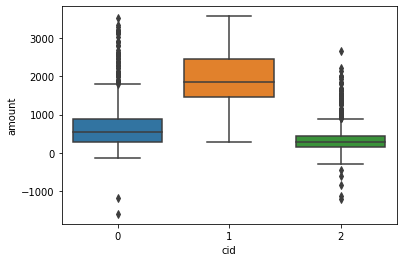

In [173]:
sns.boxplot(x='cid', y='amount', data=df5)


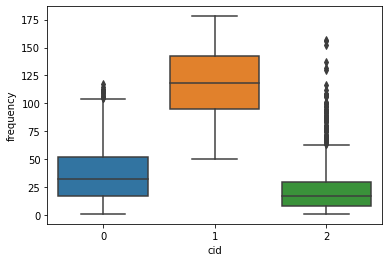

In [174]:
sns.boxplot(x='cid', y='frequency', data=df5)


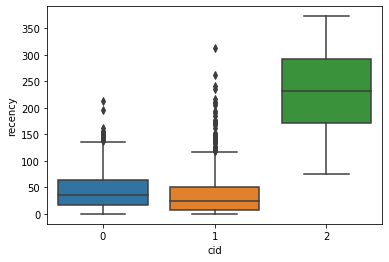

In [175]:
sns.boxplot(x='cid', y='recency', data=df5)



### Final Analysis:

K-Means Clustering with 3 Cluster Ids

    Customers with Cluster Id 0 are the customers with least amount of purchase, have purchased less no of times and many days have elapsed since their last purchase.
    
    Customers with Cluster Id 1 are are the customers with highest amount of purchase, have purchased most no of times and have their purchase history is the most recent.
    
    Customers with Cluster Id 2 are more frequent, recent buyers than cluster 0 but less than that of cluster 1

Hierarchical Clustering with 3 Cluster Ids

    Customers with Cluster Id 0 are more frequent, recent buyers than cluster 2 but less than that of cluster 1
    
    Customers with Cluster Id 1 are are the customers with highest amount of purchase, have purchased most no of times and have their purchase history is the most recent.
    
    Customers with Cluster Id 2 are the customers with least amount of purchase, have purchased less no of times and many days have elapsed since their last purchase.
